In [1]:
from model import *
from loss import *
from data import *
from torch import optim
from tqdm import tqdm

import pytorch_lightning as pl
from torchmetrics.detection import MeanAveragePrecision
from pytorch_lightning.loggers import TensorBoardLogger

In [2]:
class LitModel(pl.LightningModule):
    def __init__(self, detector):
        super().__init__()
        self.model = detector
        self.criterion = YOLOLoss()
        self.val_map = MeanAveragePrecision(box_format='xywh', iou_type='bbox')
    
    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=1e-3)
        # Using a scheduler is optional but can be helpful.
        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.95)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

    def training_step(self, batch, batch_idx):
        images, targets = batch
        tensor_images = torch.stack(images)
        tensor_targets = torch.stack(targets)
        output = self.model(tensor_images)
        loss = self.criterion(output, tensor_targets)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        tensor_images = torch.stack(images)
        tensor_targets = torch.stack(targets)
        output = self.model(tensor_images)
        loss = self.criterion(output, tensor_targets)
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        for i in range(len(images)):
            boxes = output_tensor_to_boxes(output[i].detach().cpu())
            boxes = nonmax_suppression(boxes)
            target = target_tensor_to_boxes(targets[i])[::BOX]
            if not boxes:
                boxes = torch.zeros((1, 5))
            preds = [
                dict(
                    boxes=torch.tensor(boxes)[:, :4].clone().detach(),
                    scores=torch.tensor(boxes)[:, 4].clone().detach(),
                    labels=torch.zeros(len(boxes)),
                )
            ]
            target = [
                dict(
                    boxes=torch.tensor(target),
                    labels=torch.zeros(len(target)),
                )
            ]
            self.val_map.update(preds, target)
    
    def on_validation_epoch_end(self):
        mAPs = {"val_" + k: v for k, v in self.val_map.compute().items()}
        mAPs_per_class = mAPs.pop("val_map_per_class")
        mARs_per_class = mAPs.pop("val_mar_100_per_class")
        self.log_dict(mAPs)
        self.val_map.reset()

        image = val_dataset[randint(0, len(val_dataset) - 1)][0].to(self.device)
        output = self.model(image.unsqueeze(0))
        boxes = output_tensor_to_boxes(output[0].detach().cpu())
        boxes = nonmax_suppression(boxes)
        img = image.permute(1, 2, 0).cpu().numpy()
        img = visualize_bbox(img.copy(), boxes=boxes)
        img = (255. * (img * np.array(STD) + np.array(MEAN))).astype(np.uint8)
        
        self.logger.experiment.add_image("detected boxes", torch.tensor(img).permute(2, 0, 1), self.current_epoch)


In [3]:
model = YOLOStamp()

In [ ]:
litmodel = LitModel(model)

In [3]:
litmodel = LitModel.load_from_checkpoint('./detection_logs/lightning_logs/version_53/checkpoints/epoch=49-step=15550.ckpt', detector=YOLOStamp())

In [4]:
logger = TensorBoardLogger("detection_logs")
epochs = 50

In [5]:
train_loader, val_loader = get_loaders(batch_size=8)

In [6]:
_, val_dataset = get_datasets()

In [7]:
trainer = pl.Trainer(accelerator="auto", max_epochs=epochs, logger=logger)
trainer.fit(model=litmodel, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                 | Params
---------------------------------------------------
0 | model     | YOLOStamp            | 118 K 
1 | criterion | YOLOLoss             | 0     
2 | val_map   | MeanAveragePrecision | 0     
---------------------------------------------------
118 K     Trainable params
0         Non-trainable params
118 K     Total params
0.474     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\javid\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\javid\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\utilities\data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
c:\Users\javid\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the v

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

C:\Users\javid\AppData\Local\Temp\ipykernel_26368\2788501559.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)[:, :4].clone().detach(),
C:\Users\javid\AppData\Local\Temp\ipykernel_26368\2788501559.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scores=torch.tensor(boxes)[:, 4].clone().detach(),


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [ ]:
%tensorboard

In [ ]:
for epoch in range(epochs):
    train_losses_epoch = []
    for images, targets in tqdm(train_loader):
        optimizer.zero_grad()
        tensor_images = torch.stack(images)
        tensor_targets = torch.stack(targets)
        output = model(tensor_images.to(device))
        loss = criterion(output, tensor_targets.to(device))
        
        train_losses_epoch.append(loss.item())
        
        loss.backward()
        optimizer.step()
    val_losses_epoch = []
    with torch.no_grad():
        for images, targets in tqdm(val_loader):
            tensor_images = torch.stack(images)
            tensor_targets = torch.stack(targets)
            output = model(tensor_images.to(device))
            loss = criterion(output, tensor_targets.to(device))
            
            val_losses_epoch.append(loss.item())
    # scheduler.step()
    train_losses.append(sum(train_losses_epoch) / len(train_losses_epoch))
    val_losses.append(sum(val_losses_epoch) / len(val_losses_epoch))
    print(f"Epoch {epoch + 1}/{epochs}: Train loss: {sum(train_losses_epoch) / len(train_losses_epoch)} Val loss: {sum(val_losses_epoch) / len(val_losses_epoch)}")
    if (epoch + 1) % 1 == 0 or epochs + 1 == epochs:
        demo_image = val_dataset[randint(0, len(val_dataset) - 1)][0].to(device)
        demo_output = model(demo_image.unsqueeze(0))
        boxes = output_tensor_to_boxes(demo_output[0].detach().cpu())
        boxes = nonmax_suppression(boxes)
        img = demo_image.permute(1, 2, 0).cpu().numpy()
        img = visualize_bbox(img.copy(), boxes=boxes)
        plot_normalized_img(img, size=(4,4))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


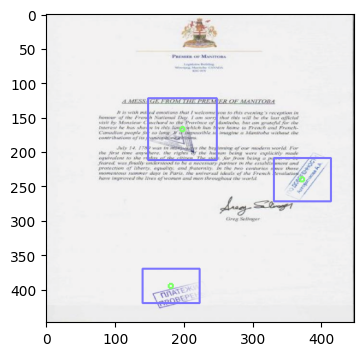

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


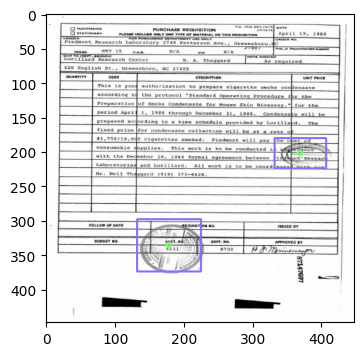

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


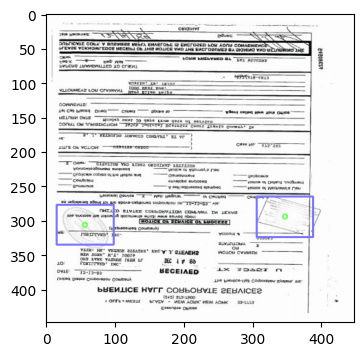

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


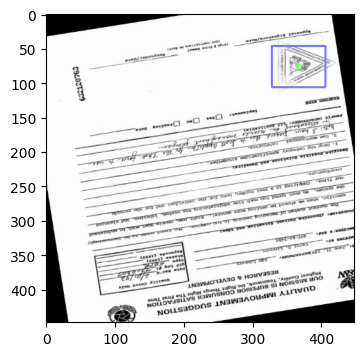

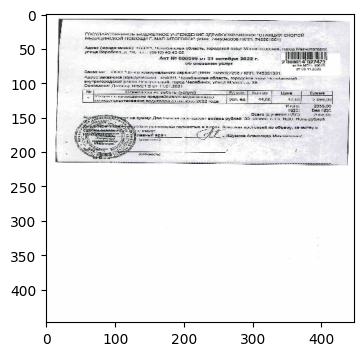

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


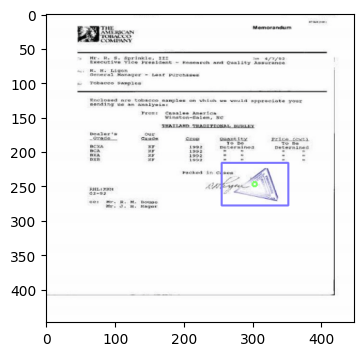

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


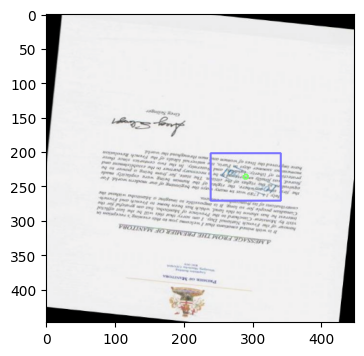

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


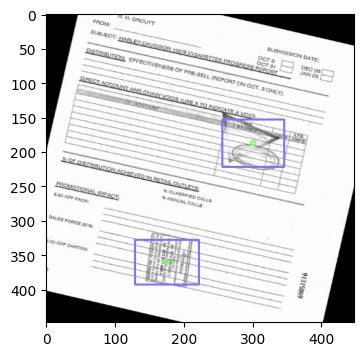

In [9]:
images, targets = next(iter(val_loader))
tensor_images = torch.stack(images)
tensor_targets = torch.stack(targets)
output = litmodel(tensor_images.to(litmodel.device))

for i in range(len(images)):
    boxes = output_tensor_to_boxes(output[i].detach().cpu())
    boxes = nonmax_suppression(boxes)
    img = images[i].permute(1, 2, 0).cpu().numpy()
    img = visualize_bbox(img.copy(), boxes=boxes)
    plot_normalized_img(img, size=(4,4))

In [9]:
torch.save(litmodel.model.state_dict(), './models/version_54.pth')

In [4]:
demo_model = YOLOStamp()
demo_model.load_state_dict(torch.load('./models/version_51.pth'))

<All keys matched successfully>

In [13]:
demo_litmodel = LitModel.load_from_checkpoint('./detection_logs/lightning_logs/version_51/checkpoints/epoch=49-step=15550.ckpt', detector=YOLOStamp())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


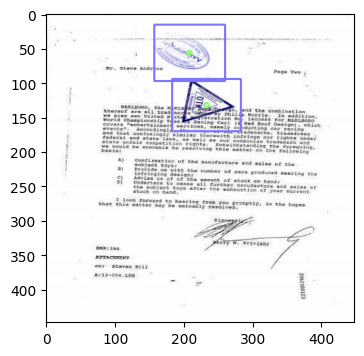

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


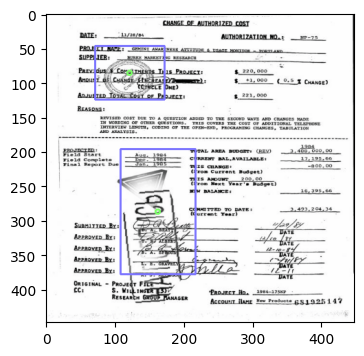

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


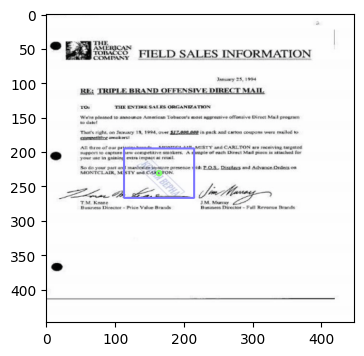

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


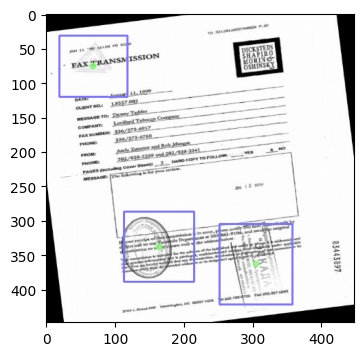

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


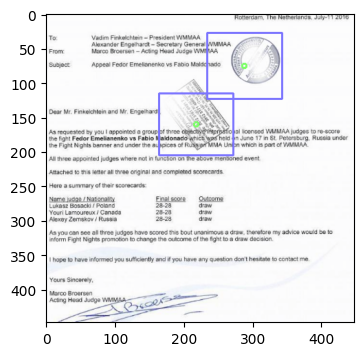

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


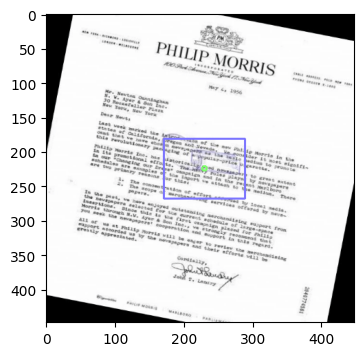

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


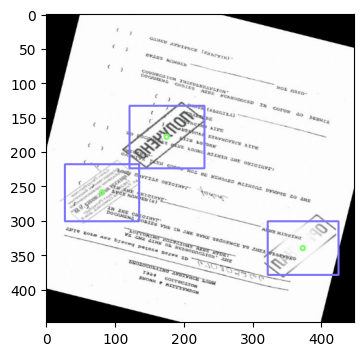

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


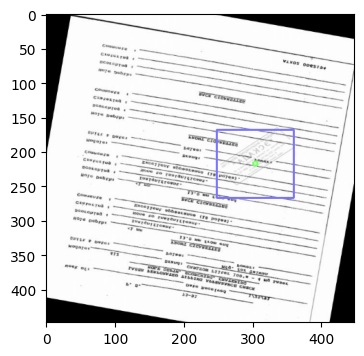

In [15]:
images, targets = next(iter(val_loader))
tensor_images = torch.stack(images)
tensor_targets = torch.stack(targets)
output = demo_model(tensor_images)

for i in range(len(images)):
    boxes = output_tensor_to_boxes(output[i].detach().cpu())
    boxes = nonmax_suppression(boxes)
    img = images[i].permute(1, 2, 0).cpu().numpy()
    img = visualize_bbox(img.copy(), boxes=boxes)
    plot_normalized_img(img, size=(4,4))